In [6]:
import torch
import time

def test_mm_perf(
    dense_shape=(4096, 4096),
    sparse_shape=(4096, 4096),
    sparse_density=0.05,
    dtype=torch.float16,
    device='cuda'
):
    # 生成密集矩阵
    a = torch.randn(dense_shape, dtype=dtype, device=device)
    b = torch.randn((dense_shape[1], dense_shape[0]), dtype=dtype, device=device)

    # 生成稀疏矩阵
    indices = torch.nonzero(torch.rand(sparse_shape, device=device) < sparse_density, as_tuple=False).t()
    values = torch.randn(indices.shape[1], dtype=torch.float32, device=device)
    sparse_mat = torch.sparse_coo_tensor(indices, values, sparse_shape, dtype=torch.float32, device=device)
    dense_vec = torch.randn((sparse_shape[1],), dtype=dtype, device=device)
    # dense_m = torch.randn(dense_shape, dtype=dtype, device=device)
    indices2 = torch.nonzero(torch.rand(sparse_shape, device=device) < sparse_density, as_tuple=False).t()
    values2 = torch.randn(indices2.shape[1], dtype=torch.float32, device=device)
    sparse_mat2 = torch.sparse_coo_tensor(indices2, values2, sparse_shape, dtype=torch.float32, device=device)

    # 预热
    for _ in range(5):
        torch.matmul(a, b)
        torch.sparse.mm(sparse_mat, b)

    torch.cuda.synchronize()
    # 测试密集矩阵乘法
    start = time.time()
    torch.matmul(a, b)
    torch.cuda.synchronize()
    dense_time = time.time() - start

    # 测试稀疏矩阵乘法
    start = time.time()
    torch.sparse.mm(sparse_mat, b)
    torch.cuda.synchronize()
    sparse_time = time.time() - start

    print(f"Dense matmul time: {dense_time * 1000:.2f} ms")
    print(f"Sparse matmul time: {sparse_time * 1000:.2f} ms")

if __name__ == "__main__":
    test_mm_perf(
        dense_shape=(4096, 4096),
        sparse_shape=(4096, 4096),
        sparse_density=0.01,
        dtype=torch.float32,
        device='cuda' if torch.cuda.is_available() else 'cpu'
    )

Dense matmul time: 7.32 ms
Sparse matmul time: 6.63 ms


In [14]:
import torch
import time
import matplotlib.pyplot as plt

def test_sparse_time_vs_density(
    shape=(4096, 4096),
    densities=None,
    dtype=torch.float32,
    device='cuda'
):
    if densities is None:
        densities = torch.tensor(range(0, 25, 2))/1000
    times = []

    # 先测一次密集矩阵乘法时间
    a = torch.randn(shape, dtype=dtype, device=device)
    b = torch.randn((shape[1], shape[0]), dtype=dtype, device=device)
    for _ in range(3):
        torch.matmul(a, b)
    torch.cuda.synchronize()
    start = time.time()
    torch.matmul(a, b)
    torch.cuda.synchronize()
    dense_time = (time.time() - start) * 1000
    print(f"Dense matmul time: {dense_time:.2f} ms")

    for d in densities:
        indices = torch.nonzero(torch.rand(shape, device=device) < d, as_tuple=False).t()
        values = torch.randn(indices.shape[1], dtype=torch.float32, device=device)
        sparse_mat = torch.sparse_coo_tensor(indices, values, shape, dtype=torch.float32, device=device)
        # 稀疏乘法用float32
        for _ in range(3):
            torch.sparse.mm(sparse_mat, b.to(torch.float32))
        torch.cuda.synchronize()
        start = time.time()
        torch.sparse.mm(sparse_mat, b.to(torch.float32))
        torch.cuda.synchronize()
        t = time.time() - start
        times.append(t * 1000)
        print(f"density={d:.3f}, time={t*1000:.2f} ms")
    plt.plot(densities, times, marker='o', label='Sparse MatMul')
    plt.axhline(y=dense_time, color='r', linestyle='--', label='Dense MatMul')
    plt.xlabel("Sparse Density")
    plt.ylabel("MatMul Time (ms)")
    plt.title("Sparse matrix multiplication time varies with sparsity ratio")
    plt.legend()
    plt.grid(True)
    plt.show()

Dense matmul time: 7.32 ms
density=0.000, time=0.15 ms
density=0.002, time=2.11 ms
density=0.004, time=3.30 ms
density=0.006, time=4.36 ms
density=0.008, time=5.48 ms
density=0.010, time=6.61 ms
density=0.012, time=7.82 ms
density=0.014, time=8.99 ms
density=0.016, time=10.15 ms
density=0.018, time=11.39 ms
density=0.020, time=12.53 ms
density=0.022, time=13.73 ms
density=0.024, time=14.92 ms


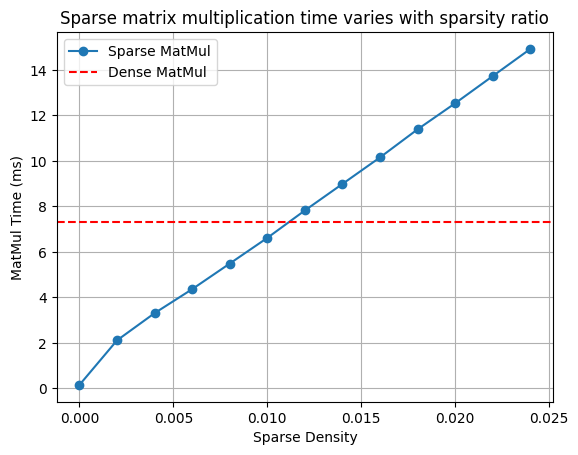

In [15]:
test_sparse_time_vs_density(
    shape=(4096, 4096),
    dtype=torch.float32,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

Dense matmul time: 0.64 ms
density=0.000, time=0.23 ms
density=0.002, time=2.19 ms
density=0.004, time=3.39 ms
density=0.006, time=4.46 ms
density=0.008, time=5.58 ms
density=0.010, time=6.73 ms
density=0.012, time=7.86 ms
density=0.014, time=9.09 ms
density=0.016, time=10.29 ms
density=0.018, time=11.47 ms
density=0.020, time=12.60 ms
density=0.022, time=13.82 ms
density=0.024, time=15.01 ms


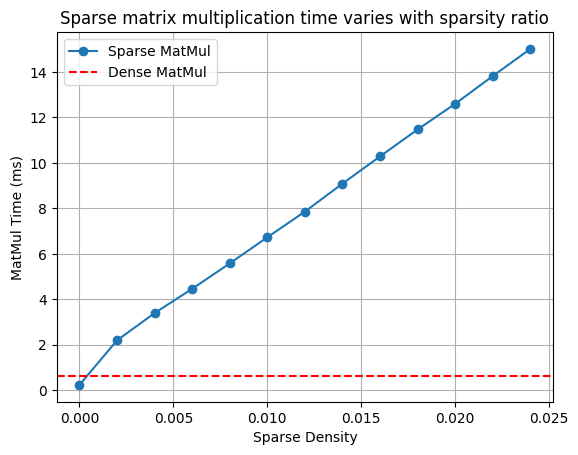

In [16]:
test_sparse_time_vs_density(
    shape=(4096, 4096),
    dtype=torch.float16,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)